# Transfer learning experiments

This notebook includes:
1) Implement a transfer learning from ImageNet > 13 diseases > 1 disease. 
2) Compared performance against ImageNet > 1 disease and ImageNet > MURA > 1 disease 

Results for disease corresponding to index 10.

## Imports & global variables

We choose `idx=10` because from previous experiments we have detected a strong signal and a sufficient amount of positive cases. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys; sys.path.append("..")
import warnings; warnings.filterwarnings('ignore')

from core import * 
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop, balance_obs, multi_label_2_binary, DataBatches
from utils import save_model, load_model, lr_loss_plot, resize
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel, lr_finder, validate_binary, TTA_binary

seed = 42
r_pix = 8
# IDX = 6 # Pneumonia
BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=r_pix)]
PRETRAINED = True
NORMALIZE = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
DATA = 'Pneumonia'
DISEASE = 'Hernia'


BASE_PATH = Path('../..')
PATH = BASE_PATH/'data'
# SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
# SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/chexPert-model'
IMG_FOLDER = PATH/'ChestXRay-250'

idx2tgt = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

tgt2idx = {disease: i for i, disease in enumerate(idx2tgt)}

# Downstream task - 1 label (small data)

Balance training and testing.

In [2]:
# # To balance validation and testing
# def decode_labels(df_col):
#     return np.array(list(map(np.array, df_col.str.split(' ')))).astype(int)

# def subset_df(df, amt, idx=tgt2idx[DISEASE]):
    
#     lbls = decode_labels(df.Label)
    
#     pos_idxs = lbls[:,idx].astype(bool)

#     neg = df[~pos_idxs].sample(n=amt//2, replace=False)
#     pos = df[pos_idxs].sample(n=amt//2, replace=False)

#     return pd.concat([neg, pos]).reset_index(drop=True)

In [4]:
train_df = pd.read_csv(PATH/'train_df.csv')
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

train_df = multi_label_2_binary(train_df, tgt2idx[DISEASE])
sample_train_df = balance_obs(train_df, amt=2000)

valid_df = multi_label_2_binary(valid_df, tgt2idx[DISEASE])
valid_df = balance_obs(valid_df, amt=2*len(valid_df[valid_df['Label']==1]))

test_df = multi_label_2_binary(test_df, tgt2idx[DISEASE])
test_df = balance_obs(test_df, amt=2*len(test_df[test_df['Label']==1]))

In [5]:
train_dl = DataBatches(df=sample_train_df, transforms=TRANSFORMATIONS, shuffle=True,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

valid_dl = DataBatches(df=valid_df, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

test_dl = DataBatches(df=test_df, transforms=TRANSFORMATIONS, shuffle=False, 
                      img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                      r_pix=r_pix, normalize=NORMALIZE, seed=seed)

A Jupyter Widget

A Jupyter Widget

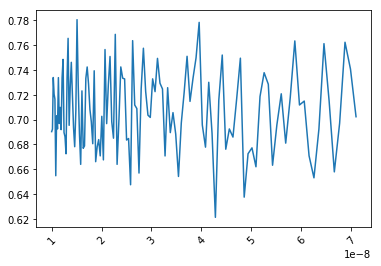

A Jupyter Widget

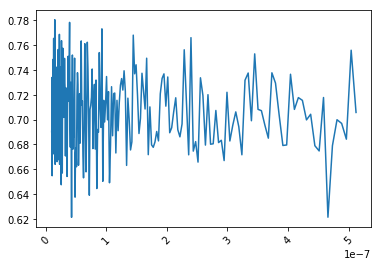

A Jupyter Widget

In [6]:
m = DenseNet121(out_size=1, pretrained=PRETRAINED, freeze=False).cuda()
lrs, losses = lr_finder(m, n_epochs=7, train_dl=train_dl, min_lr=1e-8, max_lr=1e-2,early_stopping=251, plot_every=125)

In [15]:
def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in tqdm_notebook(train_dl, leave=False):

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x).squeeze()
            loss = F.binary_cross_entropy_with_logits(input=out.squeeze(), target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Comparison on the Downstream task

\# Samples = 2,000

In [10]:
# train_df = pd.read_csv('train_df_small.csv')
# valid_df = pd.read_csv(PATH/"val_df.csv")
# test_df = pd.read_csv(PATH/"test_df.csv")

# train_df = multi_label_2_binary(train_df, tgt2idx['Pneumonia'])
# sample_train_df = balance_obs(train_df, amt=2000)

# valid_df = multi_label_2_binary(valid_df, tgt2idx['Pneumonia'])
# valid_df = balance_obs(valid_df, amt=2*len(valid_df[valid_df['Label']==1]))

# test_df = multi_label_2_binary(test_df, tgt2idx['Pneumonia'])
# test_df = balance_obs(test_df, amt=2*len(test_df[test_df['Label']==1]))

# train_dl = DataBatches(df=sample_train_df, transforms=TRANSFORMATIONS, shuffle=True,
#                        img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA, 
#                        r_pix=r_pix, normalize=NORMALIZE, seed=seed)

# valid_dl = DataBatches(df=valid_df, transforms=None, shuffle=False,
#                        img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
#                        r_pix=r_pix, normalize=NORMALIZE, seed=seed)

# test_dl = DataBatches(df=test_df, transforms=TRANSFORMATIONS, shuffle=False, 
#                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
#                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

## ImageNet

In [27]:
pretrained = True
model = DenseNet121(1, pretrained=PRETRAINED, freeze=FREEZE).cuda()
model_p = 'best_imagenet_{DISEASE}.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

print('Testing with TTA ....')
load_model(model, model_p)
TTA_binary(model, test_dl)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.6974 -  val loss 0.6727 AUC 0.6438


A Jupyter Widget

Ep. 2 - train loss 0.5796 -  val loss 0.5312 AUC 0.8373


A Jupyter Widget

Ep. 3 - train loss 0.5138 -  val loss 0.6222 AUC 0.8347


A Jupyter Widget

Ep. 4 - train loss 0.4792 -  val loss 0.4620 AUC 0.8760


A Jupyter Widget

Ep. 5 - train loss 0.3956 -  val loss 0.4729 AUC 0.8791


A Jupyter Widget

Ep. 6 - train loss 0.3587 -  val loss 0.5145 AUC 0.8669


A Jupyter Widget

Ep. 7 - train loss 0.2712 -  val loss 0.6556 AUC 0.8427


A Jupyter Widget

Ep. 8 - train loss 0.2010 -  val loss 0.5827 AUC 0.8625


A Jupyter Widget

Ep. 9 - train loss 0.1433 -  val loss 0.6240 AUC 0.8643


A Jupyter Widget

Ep. 10 - train loss 0.1104 -  val loss 0.6235 AUC 0.8625
Testing with TTA ....
TTA loss 0.5749  auc 0.8615  accuracy 0.7278


(0.574909344489353, 0.8615451065543099, 0.7278133577310155)

## MURA

In [28]:
pretrained = 'MURA'

model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
model_p = f'best_MURA_{DISEASE}.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

print('Testing with TTA ....')
load_model(model, model_p)
TTA_binary(model, test_dl)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.7017 -  val loss 0.6568 AUC 0.6709


A Jupyter Widget

Ep. 2 - train loss 0.5734 -  val loss 0.5231 AUC 0.8198


A Jupyter Widget

Ep. 3 - train loss 0.4982 -  val loss 0.7245 AUC 0.8096


A Jupyter Widget

Ep. 4 - train loss 0.4748 -  val loss 0.5351 AUC 0.8741


A Jupyter Widget

Ep. 5 - train loss 0.3779 -  val loss 0.5255 AUC 0.8686


A Jupyter Widget

Ep. 6 - train loss 0.3441 -  val loss 0.4903 AUC 0.8850


A Jupyter Widget

Ep. 7 - train loss 0.2471 -  val loss 0.4804 AUC 0.8914


A Jupyter Widget

Ep. 8 - train loss 0.1728 -  val loss 0.5443 AUC 0.8803


A Jupyter Widget

Ep. 9 - train loss 0.1283 -  val loss 0.5691 AUC 0.8754


A Jupyter Widget

Ep. 10 - train loss 0.0845 -  val loss 0.5862 AUC 0.8712
Testing with TTA ....
TTA loss 0.5935  auc 0.8685  accuracy 0.7749


(0.5934741154981118, 0.8685396296317999, 0.7749313815187557)

## CheXpert

In [29]:
pretrained = 'chexpert'

model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
model_p = 'best_chexpert_{DISEASE}.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

print('Testing with TTA ....')
load_model(model, model_p)
TTA_binary(model, test_dl)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.6996 -  val loss 0.6781 AUC 0.6918


A Jupyter Widget

Ep. 2 - train loss 0.6193 -  val loss 0.5178 AUC 0.8370


A Jupyter Widget

Ep. 3 - train loss 0.4949 -  val loss 0.4601 AUC 0.8687


A Jupyter Widget

Ep. 4 - train loss 0.4270 -  val loss 0.4504 AUC 0.8911


A Jupyter Widget

Ep. 5 - train loss 0.3845 -  val loss 0.4693 AUC 0.8833


A Jupyter Widget

Ep. 6 - train loss 0.3149 -  val loss 0.5719 AUC 0.8830


A Jupyter Widget

Ep. 7 - train loss 0.2682 -  val loss 0.5410 AUC 0.8670


A Jupyter Widget

Ep. 8 - train loss 0.2177 -  val loss 0.6265 AUC 0.8543


A Jupyter Widget

Ep. 9 - train loss 0.1901 -  val loss 0.5922 AUC 0.8640


A Jupyter Widget

Ep. 10 - train loss 0.1676 -  val loss 0.5774 AUC 0.8657
Testing with TTA ....
TTA loss 0.5127  auc 0.8896  accuracy 0.7694


(0.5126525787508825, 0.8895583556341653, 0.7694419030192132)

## 13 diseases

In [30]:
# pretrained = '13diseases'
# model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
# model_p = 'best_13diseases.pth'
# train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
#       unfreeze_during_loop=(.1, .2) if FREEZE else None)

# print('Testing with TTA ....')
# load_model(model, model_p)
# TTA_binary(model, test_dl)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.6636 -  val loss 0.6110 AUC 0.8269


A Jupyter Widget

Ep. 2 - train loss 0.5548 -  val loss 0.4577 AUC 0.8669


A Jupyter Widget

Ep. 3 - train loss 0.4671 -  val loss 0.4758 AUC 0.8655


A Jupyter Widget

Ep. 4 - train loss 0.3996 -  val loss 0.4694 AUC 0.8766


A Jupyter Widget

Ep. 5 - train loss 0.3138 -  val loss 0.4853 AUC 0.8754


A Jupyter Widget

Ep. 6 - train loss 0.2925 -  val loss 0.4937 AUC 0.8850


A Jupyter Widget

Ep. 7 - train loss 0.2099 -  val loss 0.5619 AUC 0.8781


A Jupyter Widget

Ep. 8 - train loss 0.1398 -  val loss 0.6142 AUC 0.8619


A Jupyter Widget

Ep. 9 - train loss 0.1209 -  val loss 0.6214 AUC 0.8651


A Jupyter Widget

Ep. 10 - train loss 0.1018 -  val loss 0.6615 AUC 0.8605
Testing with TTA ....
TTA loss 0.5056  auc 0.8640  accuracy 0.7694


(0.5056051797449098, 0.8640429113488565, 0.7694419030192132)

## Script

In [1]:
%%writefile hernia-downstream.py

import sys; sys.path.append("..")
import warnings; warnings.filterwarnings('ignore')

from core import * 
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop, balance_obs, multi_label_2_binary, DataBatches
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel, lr_finder, validate_binary, TTA_binary
import json

SEED = 42
R_PIX = 8
IDX = 10
BATCH_SIZE = 16
EPOCHS = 30
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=R_PIX)]
NORMALIZE = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
n_samples = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]
# n_samples = [6, 12, 24, 36, 48]

print(n_samples)
BASE_PATH = Path('/data/miguel/practicum/')
PATH = BASE_PATH/'data'
IMG_FOLDER = PATH/'ChestXRay-250'
DATA = 'Pneumonia' # will take advantage of the dataset structure for pneumonia 
DISEASE = 'Hernia'

idx2tgt = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
tgt2idx = {disease: i for i, disease in enumerate(idx2tgt)}

# To balance validation and testing
def decode_labels(df_col):
    return np.array(list(map(np.array, df_col.str.split(' ')))).astype(int)

def subset_df(df, amt, idx=IDX):
    
    lbls = decode_labels(df.Label)
    
    pos_idxs = lbls[:,idx].astype(bool)

    neg = df[~pos_idxs].sample(n=amt//2, replace=False)
    pos = df[pos_idxs].sample(n=amt//2, replace=False)

    return pd.concat([neg, pos]).reset_index(drop=True)

def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in range(n_epochs):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in train_dl:

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out.squeeze(), target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss
            
            
train_df = pd.read_csv(PATH/'train_df.csv')
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

train_df = multi_label_2_binary(train_df, tgt2idx[DISEASE])

valid_df = multi_label_2_binary(valid_df, tgt2idx[DISEASE])
valid_df = balance_obs(valid_df, amt=2*len(valid_df[valid_df['Label']==1]))

test_df = multi_label_2_binary(test_df, tgt2idx[DISEASE])
test_df = balance_obs(test_df, amt=2*len(test_df[test_df['Label']==1]))

no_pretrained = {'loss': [],
           'auc': [],
           'accuracy': []}

imagenet = {'loss': [],
           'auc': [],
           'accuracy': []}

MURA = {'loss': [],
           'auc': [],
           'accuracy': []}

chexpert = {'loss': [],
           'auc': [],
           'accuracy': []}

for N in n_samples:
    
    train_df_balanced = balance_obs(train_df, amt=N)

    train_dl = DataBatches(df=train_df_balanced, transforms=TRANSFORMATIONS, shuffle=True,
                           img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                           r_pix=R_PIX, normalize=NORMALIZE, seed=SEED)

    valid_dl = DataBatches(df=valid_df, transforms=None, shuffle=False,
                           img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                           r_pix=R_PIX, normalize=NORMALIZE, seed=SEED)

    test_dl = DataBatches(df=test_df, transforms=TRANSFORMATIONS, shuffle=False,
                          img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                          r_pix=R_PIX, normalize=NORMALIZE, seed=SEED)
    
    print('ImageNet...')
    pretrained = True
    model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
    model_p = f'models/best_{DISEASE.lower()}_{N}_imagenet.pth'
    train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
          unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None)
    
    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    imagenet['loss'].append(loss)
    imagenet['auc'].append(auc)
    imagenet['accuracy'].append(accuracy)
    
    print('MURA...')
    pretrained = 'MURA'
    model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
    model_p = f'models/best_{DISEASE.lower()}_{N}_MURA.pth'
    train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
          unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None)

    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    MURA['loss'].append(loss)
    MURA['auc'].append(auc)
    MURA['accuracy'].append(accuracy)
    
    print('CheXPert...')
    pretrained = 'chexpert'
    model = DenseNet121(1, pretrained=pretrained, freeze=FREEZE).cuda()
    model_p = f'models/best_{DISEASE.lower()}_{N}_chexpert.pth'
    train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
          unfreeze_during_loop=(.1, .2) if GRADUAL_UNFREEZING else None)

    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    chexpert['loss'].append(loss)
    chexpert['auc'].append(auc)
    chexpert['accuracy'].append(accuracy)
    
    train_dl = DataBatches(df=train_df_balanced, transforms=TRANSFORMATIONS, shuffle=True,
                           img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                           r_pix=R_PIX, normalize=False, seed=SEED)

    valid_dl = DataBatches(df=valid_df, transforms=None, shuffle=False,
                           img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                           r_pix=R_PIX, normalize=False, seed=SEED)

    test_dl = DataBatches(df=test_df, transforms=TRANSFORMATIONS, shuffle=False,
                          img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                          r_pix=R_PIX, normalize=False, seed=SEED)

    print('No pretrained...')
    pretrained = True
    model = DenseNet121(1, pretrained=False, freeze=False).cuda()
    model_p = f'models/best_{DISEASE.lower()}_{N}_no_pretrained.pth'
    train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p,
          unfreeze_during_loop=None)

    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    no_pretrained['loss'].append(loss)
    no_pretrained['auc'].append(auc)
    no_pretrained['accuracy'].append(accuracy)

imagenet = json.dumps(imagenet)
with open(f'data_plots/imagenet_{DISEASE.lower()}.json', 'w') as f:
# with open('data_plots/imagenet_small.json', 'w') as f:
    f.write(imagenet)

MURA = json.dumps(MURA)
with open(f'data_plots/MURA_{DISEASE.lower()}.json', 'w') as f:
# with open('data_plots/MURA_small.json', 'w') as f:
    f.write(MURA)
    
chexpert = json.dumps(chexpert)
with open(f'data_plots/chexpert_{DISEASE.lower()}.json', 'w') as f:
# with open('data_plots/chexpert_small.json', 'w') as f:
    f.write(chexpert)

no_pretrained = json.dumps(no_pretrained)
with open(f'data_plots/no_pretrained_{DISEASE.lower()}.json', 'w') as f:
# with open('data_plots/no_pretrained_small.json', 'w') as f:
    f.write(no_pretrained)


Overwriting hernia-downstream.py


In [1]:
"Test".lower() 

'test'

# Results

## 50-2000

In [10]:
import json

In [35]:
x = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]
with open('./data_plots/no_pretrained.json') as json_f:
    no_pretrained = json.load(json_f)
with open('./data_plots/imagenet.json') as json_f:
    imagenet = json.load(json_f)
with open('./data_plots/MURA.json') as json_f:
    MURA = json.load(json_f)
with open('./data_plots/chexpert.json') as json_f:
    chexpert = json.load(json_f)
with open('./data_plots/13diseases.json') as json_f:
    diseases13 = json.load(json_f)

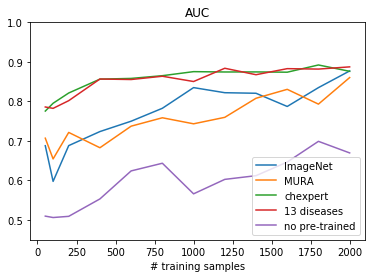

In [36]:
plt.plot(x,imagenet['auc'], label="ImageNet")
plt.plot(x,MURA['auc'], label="MURA")
plt.plot(x,chexpert['auc'], label="chexpert")
plt.plot(x,diseases13['auc'], label="13 diseases")
plt.plot(x,no_pretrained['auc'], label="no pre-trained")
plt.legend()
plt.ylim(.45,1)
plt.title('AUC')
plt.xlabel("# training samples")
plt.show()

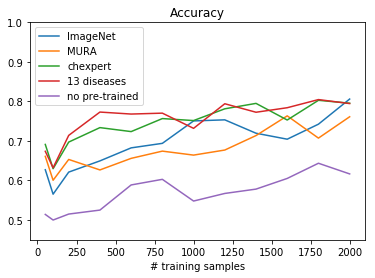

In [37]:
plt.plot(x,imagenet['accuracy'], label="ImageNet")
plt.plot(x,MURA['accuracy'], label="MURA")
plt.plot(x,chexpert['accuracy'], label="chexpert")
plt.plot(x,diseases13['accuracy'], label="13 diseases")
plt.plot(x,no_pretrained['accuracy'], label="no pre-trained")
plt.legend()
plt.ylim(.45,1)
plt.title('Accuracy')
plt.xlabel("# training samples")
plt.show()

## Spectrum 5-50

In [1]:
! ls ./data_plots/

13diseases.json        MURA_small.json	imagenet_small.json
13diseases_small.json  chexpert.json	no_pretrained.json
MURA.json	       imagenet.json	no_pretrained_small.json


In [5]:
x = [8,  16, 24, 32, 40, 48]
with open('./data_plots/no_pretrained_small.json') as json_f:
    no_pretrained = json.load(json_f)
with open('./data_plots/imagenet_small.json') as json_f:
    imagenet = json.load(json_f)
with open('./data_plots/MURA_small.json') as json_f:
    MURA = json.load(json_f)
with open('./data_plots/13diseases_small.json') as json_f:
    diseases13 = json.load(json_f)

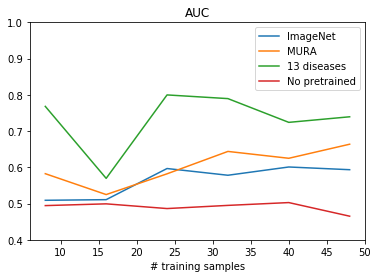

In [8]:
plt.plot(x,imagenet['auc'], label="ImageNet")
plt.plot(x,MURA['auc'], label="MURA")
plt.plot(x,diseases13['auc'], label="13 diseases")
plt.plot(x,no_pretrained['auc'], label="No pretrained")
plt.legend()
plt.ylim(.4,1)
plt.title('AUC')
plt.xlabel("# training samples")
plt.show()

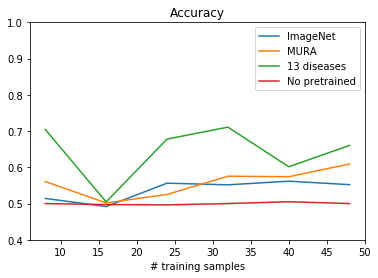

In [248]:
plt.plot(x,imagenet['accuracy'], label="ImageNet")
plt.plot(x,MURA['accuracy'], label="MURA")
plt.plot(x,diseases13['accuracy'], label="13 diseases")
plt.plot(x,no_pretrained['accuracy'], label="No pretrained")
plt.legend()
plt.ylim(.4,1)
plt.title('Accuracy')
plt.xlabel("# training samples")
plt.show()